In [2]:
import brian2 as brian
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

path_to_figs = "/Users/charliehass/Box Sync/Syncd Lab Stuff/hva_sim_data/"


In [2]:
# create the DC injections "timed_array"

dc_steps = np.array([[c,c,c,c,c,c,c,c,c,c] for c in range(0,850,50)])
dc_steps = dc_steps.transpose()

In [3]:
if 'PY_group' in vars():
    del PY_group
    del FS_group
    del SOM_group
    del Iext

brian.start_scope()

Iext = brian.TimedArray(dc_steps*brian.pamp, dt=100*brian.ms) # dt can be arbitrary relative to sim dt
Iext.unit=brian.pamp

neuron_eqs = '''
    dV/dt = (-(V - V0) + (Iext(t,i)*Rin))/tau_m : volt (unless refractory)
    tau_m : second
    Rin : ohm
    V0 : volt
    '''

N_neurons = dc_steps.shape[1]

# PY cells
PY_group = brian.NeuronGroup(N_neurons,
                            neuron_eqs,
                            threshold='V>=-0.035*volt',
                            reset='V=-0.050*volt',
                            method='euler',
                            refractory=20*brian.ms
                           )
PY_group.tau_m = 20*brian.ms # from data
PY_group.Rin = 87*brian.Mohm # from data
PY_group.V0 = -65*brian.mV # from data
PY_group.V = PY_group.V0

# SOM cells
SOM_group = brian.NeuronGroup(N_neurons,
                            neuron_eqs,
                            threshold='V>=-0.040*volt',
                            reset='V=-0.055*volt',
                            method='euler', 
                            refractory=8*brian.ms
                           )
SOM_group.tau_m = 18.2*brian.ms # from data
SOM_group.Rin = 240*brian.Mohm # from data
SOM_group.V0 = -62*brian.mV # from data
SOM_group.V = SOM_group.V0

# FS cells (all params checked out)
FS_group = brian.NeuronGroup(N_neurons,
                            neuron_eqs,
                            threshold='V>=-0.040*volt',
                            reset='V=-0.060*volt',
                            method='euler',
                            refractory=2.3*brian.ms
                           )

FS_group.tau_m = 4*brian.ms # from data
FS_group.Rin = 85*brian.Mohm # larger than data, but makes f/I relationship work
FS_group.V0 = -65*brian.mV # from data
FS_group.V = FS_group.V0


statemon = brian.StateMonitor(SOM_group, 'V', record=True)
spk_mon_som = brian.SpikeMonitor(SOM_group)
spk_mon_fs = brian.SpikeMonitor(FS_group)
spk_mon_py = brian.SpikeMonitor(PY_group)

duration = 1*brian.second
brian.run(duration)

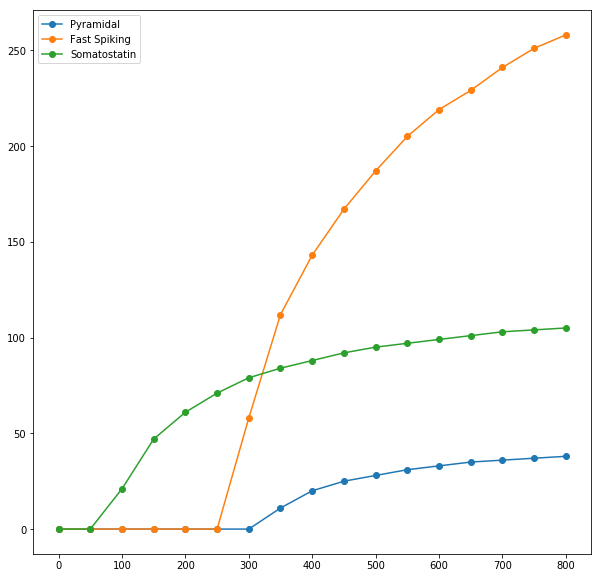

In [4]:
# make some figures: DC steps and f/i curve

plt.figure(figsize=(10,10))
lbls = ['Pyramidal', 'Fast Spiking', 'Somatostatin']
for idx, spks in enumerate([spk_mon_py, spk_mon_fs, spk_mon_som]):
    plt.plot(dc_steps[0,:], spks.count/duration, '-o', label=lbls[idx])
plt.legend()
plt.savefig('{}fI_curves_for_IAF_model.pdf'.format(path_to_figs))
plt.show()

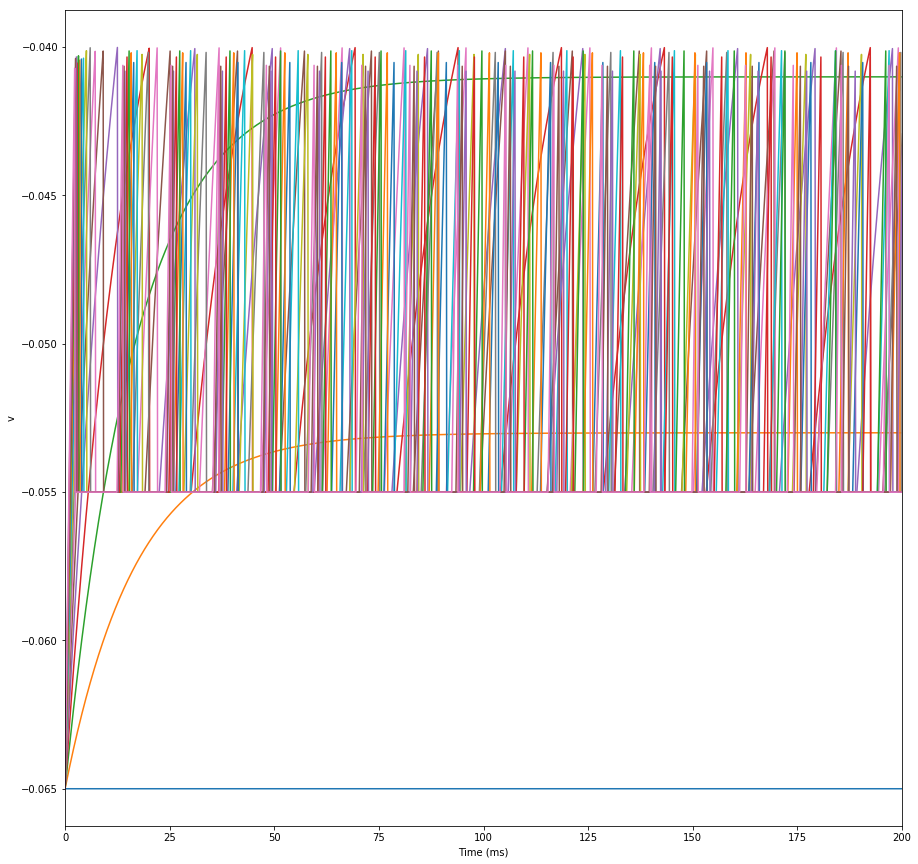

In [258]:
# subthreshold responses
plt.figure(figsize=(15,15))
for Vm in statemon.V:
    plt.plot(statemon.t/brian.ms, Vm)
plt.xlabel('Time (ms)')
plt.xlim(0, 200)
plt.ylabel('v');

In [10]:
(0.050*brian.nsiemens)*(70*brian.mvolt)

3.5 * pamp

In [9]:
# solving for the w_e and w_i in units of Siemens
# based on total number of afferents, p(connect)
# and the observed pA of an EPSC from the population of 
# stimulated V1 afferents


N_afferents_total = 1
p_afferent_connect = 1
N_afferents = N_afferents_total * p_afferent_connect
total_EPSC_on_PY = 1000 * brian.pamp
scale_fact_FS = 2.5
scale_fact_SOM = 0.18
driving_force = 70 * brian.mvolt

we_v1_onto_py = (total_EPSC_on_PY / driving_force) / N_afferents
we_v1_onto_fs = ((total_EPSC_on_PY * scale_fact_FS) / driving_force) / N_afferents
we_v1_onto_som = ((total_EPSC_on_PY * scale_fact_SOM) / driving_force) / N_afferents

print(we_v1_onto_py, we_v1_onto_fs, we_v1_onto_som)

14.28571429 nS 35.71428571 nS 2.57142857 nS


In [36]:
brian.Mohm

Mohm